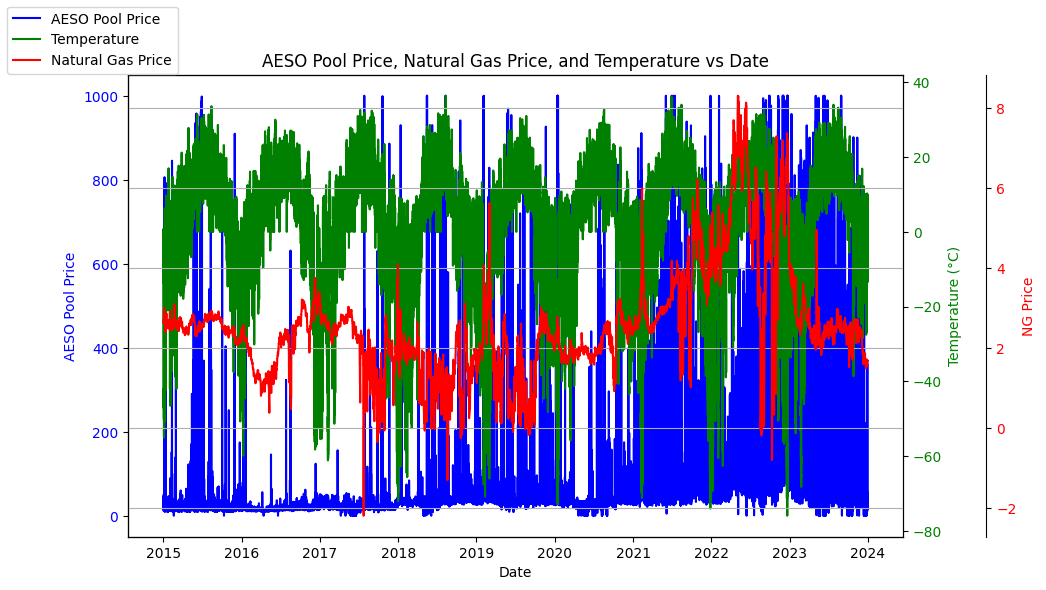

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
data = pd.read_csv('Merged Data.csv', parse_dates=['Date'])

# Create a single plot with separate y-axes for temperature and NG price
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot Pool Price
ax1.plot(data['Date'], data['AESO Pool Price CAD/MWh'], label='AESO Pool Price', color='blue')
ax1.set_xlabel('Date')
ax1.set_ylabel('AESO Pool Price', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis for the temperature
ax2 = ax1.twinx()
ax2.plot(data['Date'], data['Temp Calgary deg C'], label='Temperature', color='green')
ax2.set_ylabel('Temperature (°C)', color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Create a third y-axis for the NG price
ax3 = ax1.twinx()
ax3.spines['right'].set_position(('outward', 60))  # Offset the right spine of ax3
ax3.plot(data['Date'], data['AECO 2A CAD/GJ'], label='Natural Gas Price', color='red')
ax3.set_ylabel('NG Price', color='red')
ax3.tick_params(axis='y', labelcolor='red')

# Add a legend with custom handles
handles, labels = [], []
for ax in [ax1, ax2, ax3]:
    for h, l in zip(*ax.get_legend_handles_labels()):
        handles.append(h)
        labels.append(l)
fig.legend(handles, labels, loc='upper left')

plt.title("AESO Pool Price, Natural Gas Price, and Temperature vs Date")
plt.grid(True)
plt.show()

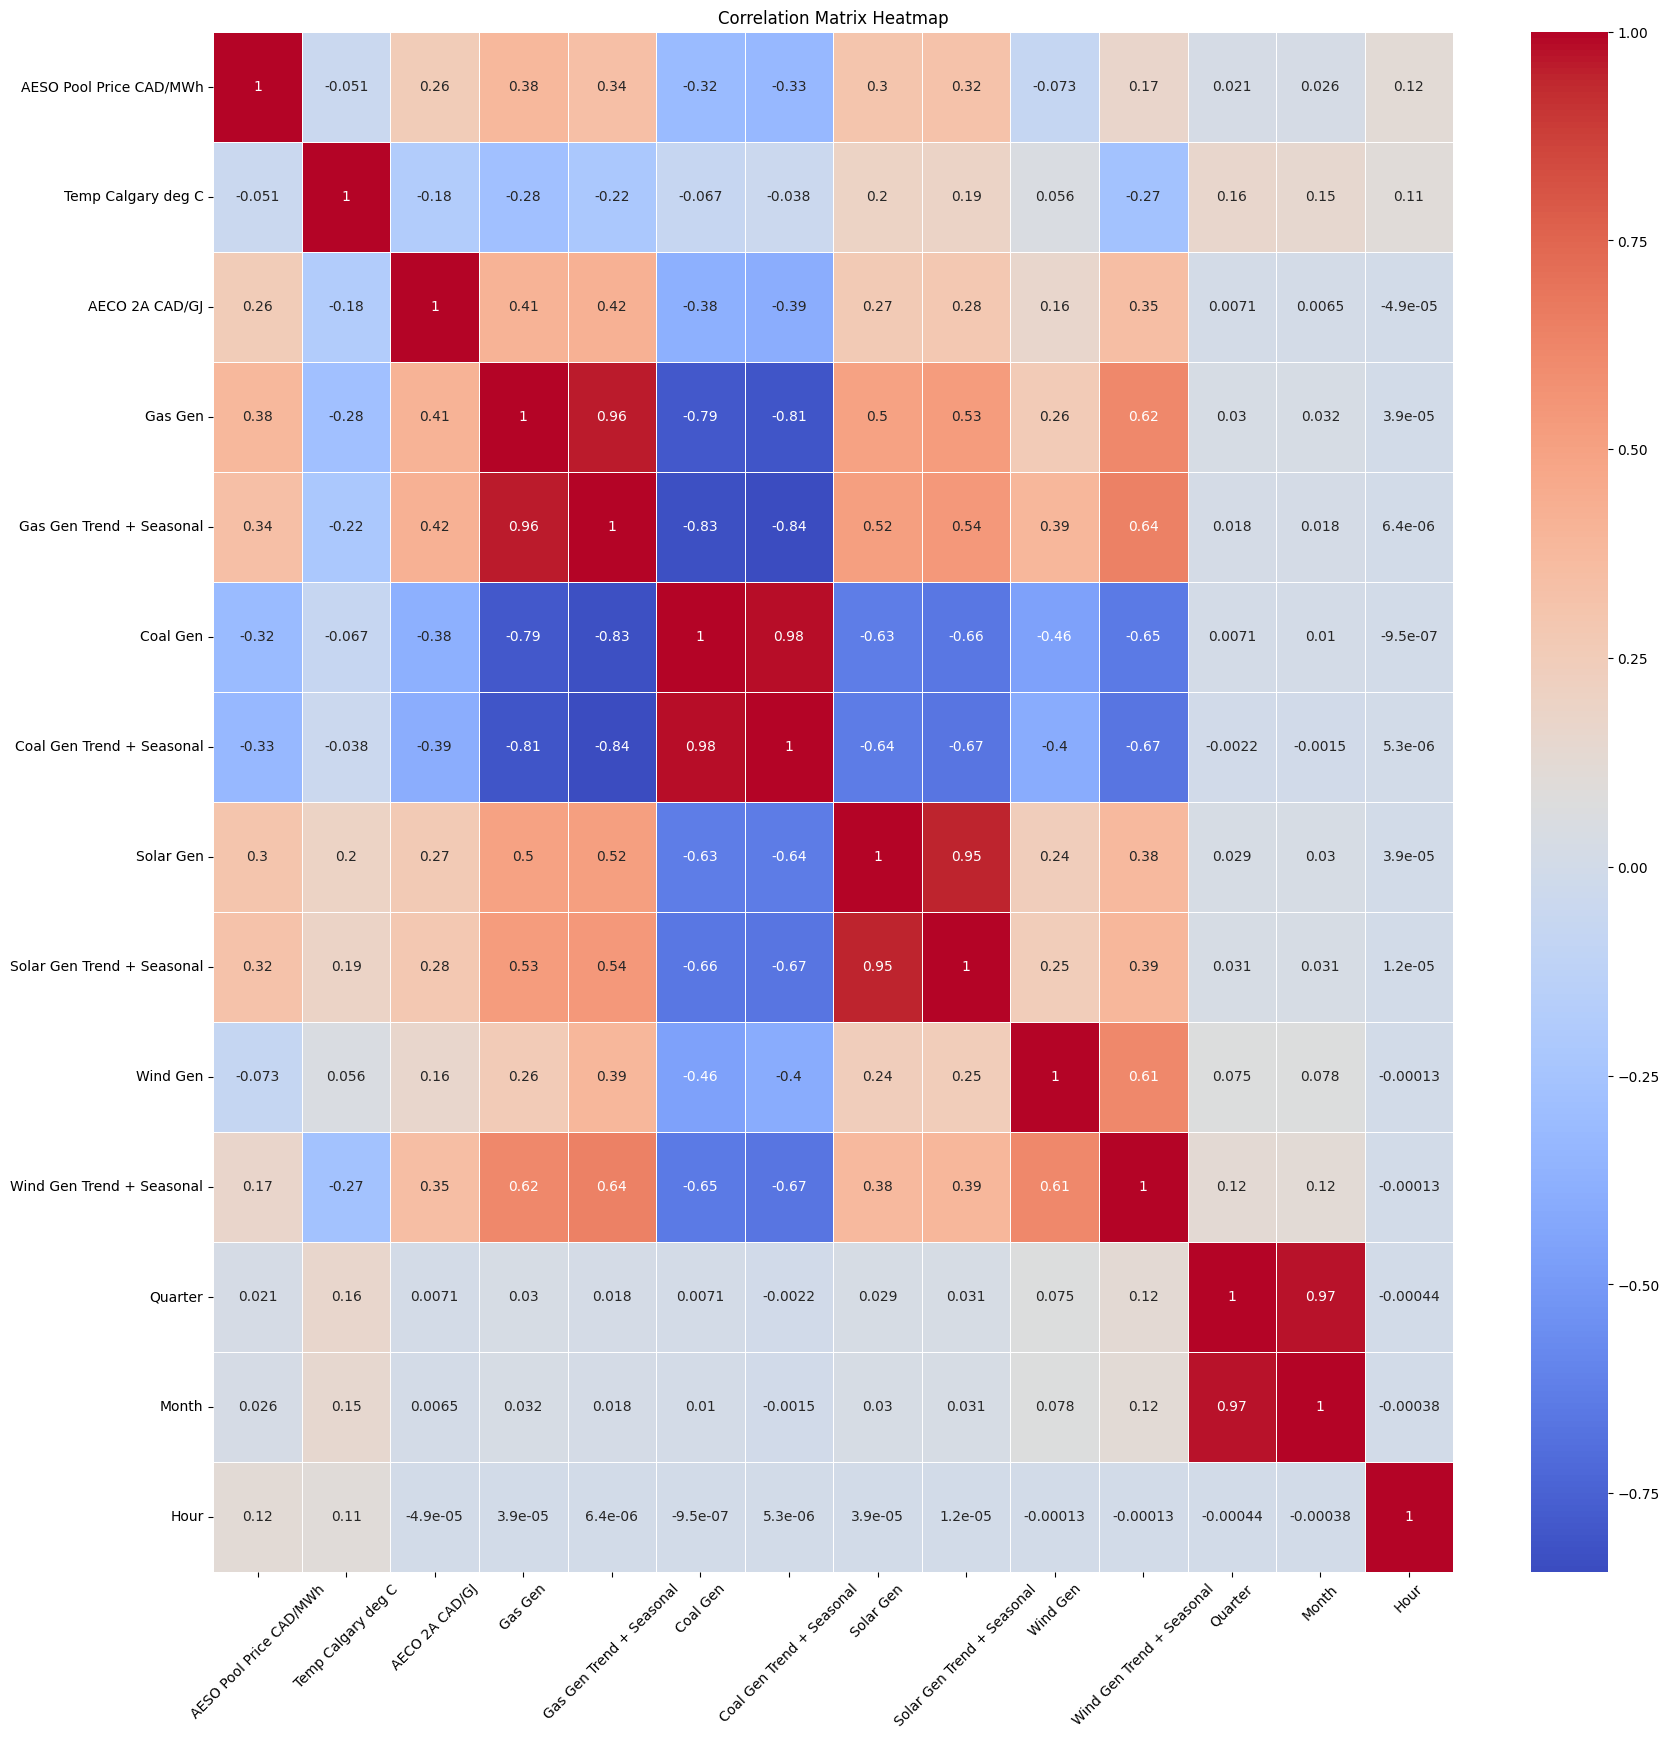

In [3]:
data_numeric = data.drop(['Date','Date Daily'], axis=1)

correlation_matrix = data_numeric.corr()

# Create a heatmap
plt.figure(figsize=(20, 20))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)

# Customize the plot (optional)
plt.title("Correlation Matrix Heatmap")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

In [4]:
data.head()

,Date,AESO Pool Price CAD/MWh,Date Daily,Temp Calgary deg C,AECO 2A CAD/GJ,Gas Gen,Gas Gen Trend + Seasonal,Coal Gen,Coal Gen Trend + Seasonal,Solar Gen,Solar Gen Trend + Seasonal,Wind Gen,Wind Gen Trend + Seasonal,Quarter,Month,Hour
0,2015-01-01 00:00:00,37.45,2015-01-01,-13.5,2.631,87172.18642,130165.3482,0.0,0.0,0.0,0.0,16123.84593,34653.46934,1,1,0
1,2015-01-01 01:00:00,34.62,2015-01-01,-2.5,2.631,87172.18642,130165.3482,0.0,0.0,0.0,0.0,16123.84593,34653.46934,1,1,1
2,2015-01-01 02:00:00,22.80,2015-01-01,-6.6,2.631,87172.18642,130165.3482,0.0,0.0,0.0,0.0,16123.84593,34653.46934,1,1,2
3,2015-01-01 03:00:00,21.05,2015-01-01,-7.6,2.631,87172.18642,130165.3482,0.0,0.0,0.0,0.0,16123.84593,34653.46934,1,1,3
4,2015-01-01 04:00:00,20.79,2015-01-01,-6.7,2.631,87172.18642,130165.3482,0.0,0.0,0.0,0.0,16123.84593,34653.46934,1,1,4


## LinearRegression Model

Temp Calgary deg C: 0.0026
AECO 2A CAD/GJ: 0.0297
Coal Gen: 0.0064
Gas Gen: 0.1528
Solar Gen: 0.0366
Wind Gen: 0.1048
Mean Squared Error: 13147.041336384513
R-squared: 0.21010136750370856


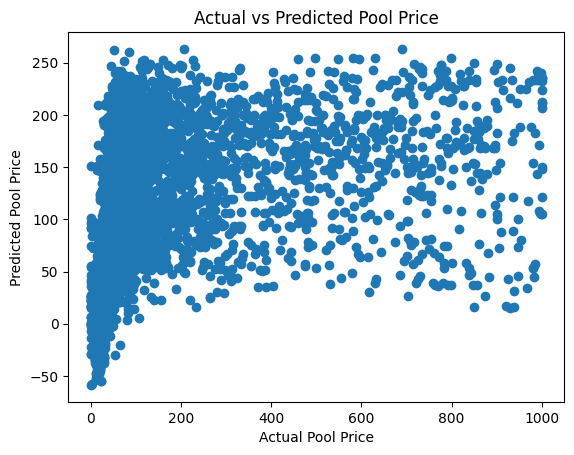

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score  # Importing the mean_squared_error function
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance

# Replace NaN values with zeros in production data
data = data.fillna(0)

# Preparing the data for modeling
X = data[['Temp Calgary deg C', 'AECO 2A CAD/GJ', 'Coal Gen', 'Gas Gen', 'Solar Gen', 'Wind Gen']]  # independent variables
y = data['AESO Pool Price CAD/MWh']  # dependent variable

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Creating the model
model = LinearRegression()

# Training the model
model.fit(X_train, y_train)

# Making predictions
y_pred = model.predict(X_test)

# Evaluating the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Compute permutation importance
perm_importance = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=0)

# Get feature importances
feature_importances = perm_importance.importances_mean

# Print feature importances
for feature, importance in zip(X.columns, feature_importances):
    print(f'{feature}: {importance:.4f}')

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

# Plotting the results
# Here we plot the predicted pool_price vs actual pool_price
plt.scatter(y_test, y_pred)
plt.xlabel('Actual Pool Price')
plt.ylabel('Predicted Pool Price')
plt.title('Actual vs Predicted Pool Price')
plt.show()


## Random Forest Regression Model - Random split data

Temp Calgary deg C: 0.4202
AECO 2A CAD/GJ: 0.0539
Coal Gen: 0.1753
Gas Gen: 0.3638
Solar Gen: 0.1213
Wind Gen: 0.2340
Random Forest Mean Squared Error: 8276.316635547357
Random Forest R-squared: 0.5027435431854367


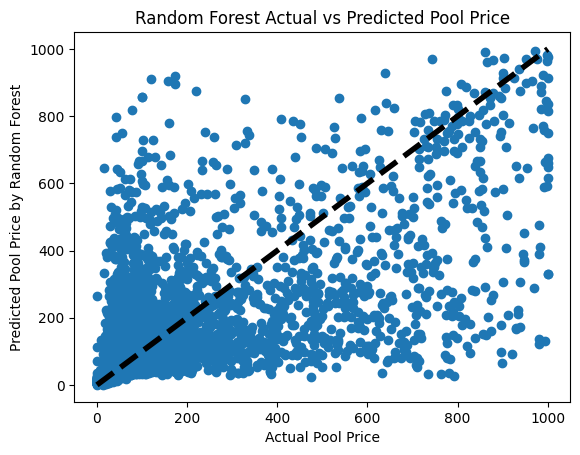

In [40]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance


# Sort the data by date
df = data.sort_values(by='Date')

# Handling NaN values using SimpleImputer
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
X_imputed = imputer.fit_transform(train_data[['Temp Calgary deg C', 'AECO 2A CAD/GJ', 'Coal Gen', 'Gas Gen', 'Solar Gen', 'Wind Gen']])

# Preparing the data for modeling
X = data[['Temp Calgary deg C', 'AECO 2A CAD/GJ', 'Coal Gen', 'Gas Gen', 'Solar Gen', 'Wind Gen']]  # independent variables
y = data['AESO Pool Price CAD/MWh']  # dependent variable

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Creating the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=0)

# Training the model
rf_model.fit(X_train, y_train)

# Making predictions
y_pred_rf = rf_model.predict(X_test)

# Evaluating the model
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

# Compute permutation importance
perm_importance = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=0)

# Get feature importances
feature_importances = perm_importance.importances_mean

# Print feature importances
for feature, importance in zip(X.columns, feature_importances):
    print(f'{feature}: {importance:.4f}')

print(f'Random Forest Mean Squared Error: {mse_rf}')
print(f'Random Forest R-squared: {r2_rf}')

# Plotting the results
plt.scatter(y_test, y_pred_rf)
plt.xlabel('Actual Pool Price')
plt.ylabel('Predicted Pool Price by Random Forest')
plt.title('Random Forest Actual vs Predicted Pool Price')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
plt.show()

## Random Forest Regression Model - split data with train 2015-2021, test 2022-2023

Temp Calgary deg C: 0.7677
AECO 2A CAD/GJ: 0.1645
Coal Gen: 0.2067
Gas Gen: 0.4575
Solar Gen: 0.1069
Wind Gen: 0.4746
Random Forest Mean Squared Error: 32658.01040398835
Random Forest R-squared: 0.11603405691301849


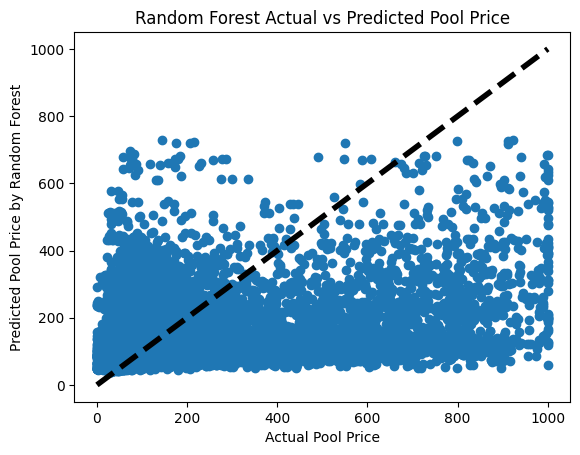

In [39]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance


# Sort the data by date
df = data.sort_values(by='Date')

# Define date ranges
start_date_1 = pd.Timestamp('2015-01-01 00:00:00')
end_date_1 = pd.Timestamp('2021-12-31 23:00:00')
start_date_2 = pd.Timestamp('2022-01-01 00:00:00')
end_date_2 = pd.Timestamp('2023-12-31 23:00:00')

# Create masks for slicing
mask_train = (df['Date'] >= start_date_1) & (df['Date'] <= end_date_1)
mask_test = (df['Date'] >= start_date_2) & (df['Date'] <= end_date_2)

# Create training and test datasets
train_data = df[mask_train]
test_data = df[mask_test]

# Handling NaN values using SimpleImputer
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
X_imputed = imputer.fit_transform(train_data[['Temp Calgary deg C', 'AECO 2A CAD/GJ', 'Coal Gen', 'Gas Gen', 'Solar Gen', 'Wind Gen']])

# Preparing the data for modeling
X_train = pd.DataFrame(X_imputed, columns=['Temp Calgary deg C', 'AECO 2A CAD/GJ', 'Coal Gen', 'Gas Gen', 'Solar Gen', 'Wind Gen'])  # independent variables
y_train = train_data['AESO Pool Price CAD/MWh'].dropna()  # dependent variable
X_test_imputed = imputer.fit_transform(test_data[['Temp Calgary deg C', 'AECO 2A CAD/GJ', 'Coal Gen', 'Gas Gen', 'Solar Gen', 'Wind Gen']])
X_test = pd.DataFrame(X_test_imputed, columns=['Temp Calgary deg C', 'AECO 2A CAD/GJ', 'Coal Gen', 'Gas Gen', 'Solar Gen', 'Wind Gen'])  # independent variables
y_test = test_data['AESO Pool Price CAD/MWh'].dropna()  # dependent variable

# Splitting the data into training and testing sets
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Creating the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=0)

# Training the model
rf_model.fit(X_train, y_train)

# Making predictions
y_pred_rf = rf_model.predict(X_test)

# Evaluating the model
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

# Compute permutation importance
perm_importance = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=0)

# Get feature importances
feature_importances = perm_importance.importances_mean

# Print feature importances
for feature, importance in zip(X.columns, feature_importances):
    print(f'{feature}: {importance:.4f}')

print(f'Random Forest Mean Squared Error: {mse_rf}')
print(f'Random Forest R-squared: {r2_rf}')

# Plotting the results
plt.scatter(y_test, y_pred_rf)
plt.xlabel('Actual Pool Price')
plt.ylabel('Predicted Pool Price by Random Forest')
plt.title('Random Forest Actual vs Predicted Pool Price')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
plt.show()

## Random Forest Regression model with X_test.index 

Mean Squared Error: 8058.94
Root Mean Squared Error: 89.77
R-squared: 0.51


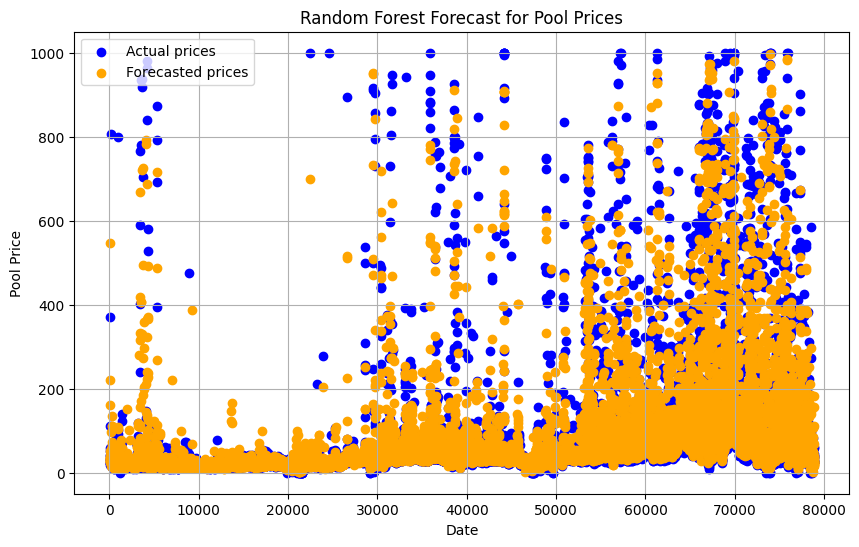

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Replace NaN values with zeros in production data
data = data.fillna(0)

# Preparing the data for modeling
X = data[['Temp Calgary deg C', 'AECO 2A CAD/GJ', 'Coal Gen', 'Gas Gen', 'Solar Gen', 'Wind Gen']]  # independent variables
y = data['AESO Pool Price CAD/MWh']  # dependent variable

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Random Forest model
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the model to the training data
model.fit(X_train, y_train)

# Predict future prices
y_pred = model.predict(X_test)

# Evaluate the model (MSE and RMSE)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f"Mean Squared Error: {mse:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f}")

# R-squared (Coefficient of Determination)
r2 = model.score(X_test, y_test)
print(f"R-squared: {r2:.2f}")

# Plot the forecast
plt.figure(figsize=(10, 6))
plt.scatter(X_test.index, y_test, label='Actual prices', color='blue')
plt.scatter(X_test.index, y_pred, label='Forecasted prices', color='orange')
plt.xlabel('Date')
plt.ylabel('Pool Price')
plt.title('Random Forest Forecast for Pool Prices')
plt.legend()
plt.grid(True)
plt.show()


## Random Forest model, try to achieve higher accuracy

In [34]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import shap

# Replace NaN values with zeros in production data
data = data.fillna(0)

# Preparing the data for modeling
X = data[['Temp Calgary deg C', 'AECO 2A CAD/GJ', 'Coal Gen', 'Gas Gen', 'Solar Gen', 'Wind Gen']]
y = data['AESO Pool Price CAD/MWh']

# Check for NaN values in y
if np.isnan(y).any():
    print("Found NaN values in the target variable (y). ")

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Initialize the model
model = RandomForestRegressor(n_estimators=100, criterion='squared_error', max_depth=None)

# Fit the model to the training data
model.fit(X_train, y_train)

# Create a SHAP explainer
explainer = shap.KernelExplainer(model.predict, X_train, link="logit")

# Compute SHAP values for the test data
shap_values = explainer.shap_values(X_test, nsamples=10)


Using 63110 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
c:\Users\gaoqian\AppData\Local\Programs\Python\Python312\Lib\site-packages\shap\utils\_legacy.py:257: RuntimeWarning: invalid value encountered in log
  return np.log(x/(1-x))
c:\Users\gaoqian\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in f (vectorized)
  outputs = ufunc(*inputs)
  0%|          | 0/15778 [00:00<?, ?it/s]c:\Users\gaoqian\AppData\Local\Programs\Python\Python312\Lib\site-packages\shap\utils\_legacy.py:257: RuntimeWarning: invalid value encountered in log
  return np.log(x/(1-x))
c:\Users\gaoqian\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in f (vectorized)
  outputs = ufunc(*inputs)
  0%|          | 0/15778 [00:10<?, ?it/s]


ValueError: Input y contains NaN.

 ## neural network model

In [8]:
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.regularizers import l2

# Handling NaN values using SimpleImputer
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
X_imputed = imputer.fit_transform(data[['Temp Calgary deg C', 'AECO 2A CAD/GJ', 'Coal Gen', 'Gas Gen', 'Solar Gen', 'Wind Gen']])

# Preparing the data for modeling
X = pd.DataFrame(X_imputed, columns=['Temp Calgary deg C', 'AECO 2A CAD/GJ', 'Coal Gen', 'Gas Gen', 'Solar Gen', 'Wind Gen'])  # independent variables
y = data['AESO Pool Price CAD/MWh'].dropna()  # dependent variable

# Ensure that the index aligns between X and y after dropping NaN values
X = X.loc[y.index]

# Standardizing the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=0)

# Creating the neural network model
model = Sequential()
model.add(Dense(10, input_dim=X_train.shape[1], activation='relu', kernel_regularizer=l2(l2=0.01)))  # Input layer and first hidden layer
model.add(Dense(5, activation='relu'))  # Second hidden layer
model.add(Dense(1, activation='linear'))  # Output layer

# Compiling the model
model.compile(loss='mean_squared_error', optimizer='adam')

# Training the model
model.fit(X_train, y_train, epochs=100, batch_size=10, verbose=1)

# Making predictions
y_pred_nn = model.predict(X_test)

# Evaluating the model
mse_nn = mean_squared_error(y_test, y_pred_nn)
r2_nn = r2_score(y_test, y_pred_nn)

print(f'Neural Network Mean Squared Error: {mse_nn}')
print(f'Neural Network R-squared: {r2_nn}')


Epoch 1/100


c:\Users\gaoqian\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6311/6311 ━━━━━━━━━━━━━━━━━━━━ 5s 643us/step - loss: 15188.8164
Epoch 2/100
6311/6311 ━━━━━━━━━━━━━━━━━━━━ 4s 632us/step - loss: 12155.5176
Epoch 3/100
6311/6311 ━━━━━━━━━━━━━━━━━━━━ 4s 614us/step - loss: 11731.5059
Epoch 4/100
6311/6311 ━━━━━━━━━━━━━━━━━━━━ 4s 616us/step - loss: 11279.9102
Epoch 5/100
6311/6311 ━━━━━━━━━━━━━━━━━━━━ 4s 640us/step - loss: 11608.2861
Epoch 6/100
6311/6311 ━━━━━━━━━━━━━━━━━━━━ 4s 592us/step - loss: 10905.5000
Epoch 7/100
6311/6311 ━━━━━━━━━━━━━━━━━━━━ 4s 578us/step - loss: 10455.5137
Epoch 8/100
6311/6311 ━━━━━━━━━━━━━━━━━━━━ 4s 591us/step - loss: 11117.0127
Epoch 9/100
6311/6311 ━━━━━━━━━━━━━━━━━━━━ 4s 588us/step - loss: 10833.7275
Epoch 10/100
6311/6311 ━━━━━━━━━━━━━━━━━━━━ 4s 579us/step - loss: 10492.8691
Epoch 11/100
6311/6311 ━━━━━━━━━━━━━━━━━━━━ 4s 574us/step - loss: 10671.4883
Epoch 12/100
6311/6311 ━━━━━━━━━━━━━━━━━━━━ 4s 587us/step - loss: 10819.0098
Epoch 13/100
6311/6311 ━━━━━━━━━━━━━━━━━━━━ 4s 576us/step - loss: 10613.1865
Epoch 14/100
6311/63

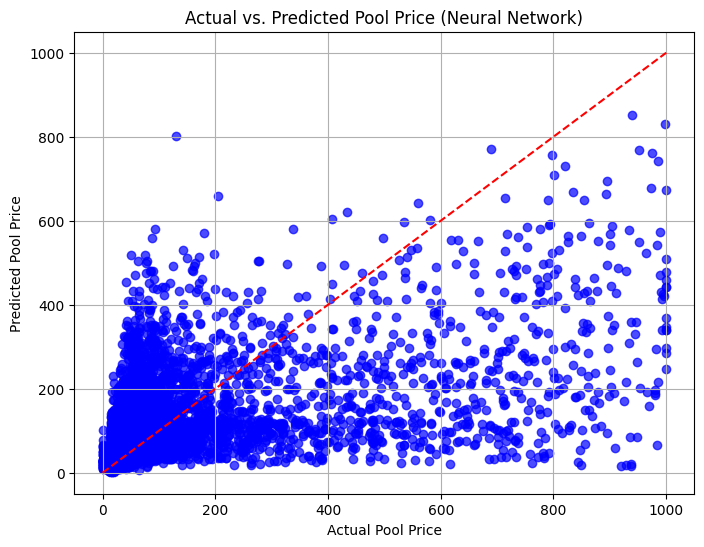

In [9]:
# Create a scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_nn, color='b', alpha=0.7)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='r', linestyle='--')
plt.xlabel('Actual Pool Price')
plt.ylabel('Predicted Pool Price')
plt.title('Actual vs. Predicted Pool Price (Neural Network)')
plt.grid(True)
plt.show()

 ## neural network model with KerasRegressor
 #### Could not interpret metric identifier: loss
 #### interupt after 23minutes running

In [43]:
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.regularizers import l2
from scikeras.wrappers import KerasRegressor
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score

def build_model():
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1],)))  # Specify the input shape explicitly
    model.add(Dense(10, activation='relu', kernel_regularizer=l2(0.01)))  # Input layer and first hidden layer
    model.add(Dense(5, activation='relu'))  # Second hidden layer
    model.add(Dense(1, activation='linear'))  # Output layer
    model.compile(loss='mean_squared_error', optimizer='RMSprop')
    return model

# Handling NaN values using SimpleImputer
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
X_imputed = imputer.fit_transform(data[['Temp Calgary deg C', 'AECO 2A CAD/GJ', 'Coal Gen', 'Gas Gen', 'Solar Gen', 'Wind Gen']])

# Preparing the data for modeling
X = pd.DataFrame(X_imputed, columns=['Temp Calgary deg C', 'AECO 2A CAD/GJ', 'Coal Gen', 'Gas Gen', 'Solar Gen', 'Wind Gen'])  # independent variables
y = data['AESO Pool Price CAD/MWh'].dropna()  # dependent variable

# Ensure that the index aligns between X and y after dropping NaN values
X = X.loc[y.index]

# Standardizing the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=0)

# Wrap the model with KerasRegressor
model = KerasRegressor(model=build_model, epochs=100, batch_size=10, verbose=1)

# Use cross_val_score with a valid scoring parameter
scores = cross_val_score(model, X_scaled, y, cv=5, scoring='neg_mean_squared_error')

# Train the model
model.fit(X_train, y_train)

# Making predictions
y_pred_nn = model.predict(X_test)

# Evaluating the model
mse_nn = mean_squared_error(y_test, y_pred_nn)
r2_nn = r2_score(y_test, y_pred_nn)

print(f'Neural Network Mean Squared Error: {mse_nn}')
print(f'Neural Network R-squared: {r2_nn}')

Epoch 1/100
6311/6311 ━━━━━━━━━━━━━━━━━━━━ 3s 393us/step - loss: 17795.5742
Epoch 2/100
6311/6311 ━━━━━━━━━━━━━━━━━━━━ 2s 374us/step - loss: 15216.0439
Epoch 3/100
6311/6311 ━━━━━━━━━━━━━━━━━━━━ 2s 366us/step - loss: 13955.9697
Epoch 4/100
6311/6311 ━━━━━━━━━━━━━━━━━━━━ 2s 378us/step - loss: 13414.9697
Epoch 5/100
6311/6311 ━━━━━━━━━━━━━━━━━━━━ 2s 355us/step - loss: 13612.8125
Epoch 6/100
6311/6311 ━━━━━━━━━━━━━━━━━━━━ 3s 411us/step - loss: 12982.4424
Epoch 7/100
6311/6311 ━━━━━━━━━━━━━━━━━━━━ 2s 378us/step - loss: 13665.4053
Epoch 8/100
6311/6311 ━━━━━━━━━━━━━━━━━━━━ 3s 418us/step - loss: 13004.6172
Epoch 9/100
6311/6311 ━━━━━━━━━━━━━━━━━━━━ 3s 398us/step - loss: 12824.4570
Epoch 10/100
6311/6311 ━━━━━━━━━━━━━━━━━━━━ 2s 389us/step - loss: 12765.6865
Epoch 11/100
6311/6311 ━━━━━━━━━━━━━━━━━━━━ 2s 375us/step - loss: 12385.5781
Epoch 12/100
6311/6311 ━━━━━━━━━━━━━━━━━━━━ 2s 391us/step - loss: 12446.0635
Epoch 13/100
6311/6311 ━━━━━━━━━━━━━━━━━━━━ 3s 411us/step - loss: 12361.7334
Epoch 14

ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\gaoqian\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\gaoqian\AppData\Local\Programs\Python\Python312\Lib\site-packages\scikeras\wrappers.py", line 735, in fit
    self._fit(
  File "c:\Users\gaoqian\AppData\Local\Programs\Python\Python312\Lib\site-packages\scikeras\wrappers.py", line 900, in _fit
    self._fit_keras_model(
  File "c:\Users\gaoqian\AppData\Local\Programs\Python\Python312\Lib\site-packages\scikeras\wrappers.py", line 515, in _fit_keras_model
    raise e
  File "c:\Users\gaoqian\AppData\Local\Programs\Python\Python312\Lib\site-packages\scikeras\wrappers.py", line 510, in _fit_keras_model
    key = metric_name(key)
          ^^^^^^^^^^^^^^^^
  File "c:\Users\gaoqian\AppData\Local\Programs\Python\Python312\Lib\site-packages\scikeras\utils\__init__.py", line 109, in metric_name
    fn_or_cls = keras_metric_get(metric)
                ^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\gaoqian\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\metrics\__init__.py", line 204, in get
    raise ValueError(f"Could not interpret metric identifier: {identifier}")
ValueError: Could not interpret metric identifier: loss


## Neural network model - simple 100 epochs

In [33]:
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Replace NaN values with zeros in data
data = data.fillna(0)

# Preparing the data for modeling
X = data[['Temp Calgary deg C', 'AECO 2A CAD/GJ', 'Coal Gen', 'Gas Gen', 'Solar Gen', 'Wind Gen']]  # independent variables
y = data['AESO Pool Price CAD/MWh']  # dependent variable

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define a simple neural network model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)  # Output layer for regression
])

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

# Train the neural network
model.fit(X_train, y_train, epochs=100, batch_size=10, verbose=1)


Epoch 1/100


c:\Users\gaoqian\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6311/6311 ━━━━━━━━━━━━━━━━━━━━ 3s 384us/step - loss: 10794923.0000
Epoch 2/100
6311/6311 ━━━━━━━━━━━━━━━━━━━━ 2s 361us/step - loss: 47283.5039
Epoch 3/100
6311/6311 ━━━━━━━━━━━━━━━━━━━━ 3s 518us/step - loss: 28487.0586
Epoch 4/100
6311/6311 ━━━━━━━━━━━━━━━━━━━━ 3s 528us/step - loss: 20394.2910
Epoch 5/100
6311/6311 ━━━━━━━━━━━━━━━━━━━━ 3s 527us/step - loss: 15577.9590
Epoch 6/100
6311/6311 ━━━━━━━━━━━━━━━━━━━━ 4s 577us/step - loss: 13264.1299
Epoch 7/100
6311/6311 ━━━━━━━━━━━━━━━━━━━━ 4s 555us/step - loss: 12461.9004
Epoch 8/100
6311/6311 ━━━━━━━━━━━━━━━━━━━━ 3s 543us/step - loss: 12236.0078
Epoch 9/100
6311/6311 ━━━━━━━━━━━━━━━━━━━━ 3s 544us/step - loss: 12539.8926
Epoch 10/100
6311/6311 ━━━━━━━━━━━━━━━━━━━━ 4s 581us/step - loss: 12322.0605
Epoch 11/100
6311/6311 ━━━━━━━━━━━━━━━━━━━━ 3s 539us/step - loss: 12242.7910
Epoch 12/100
6311/6311 ━━━━━━━━━━━━━━━━━━━━ 3s 535us/step - loss: 12144.0537
Epoch 13/100
6311/6311 ━━━━━━━━━━━━━━━━━━━━ 3s 535us/step - loss: 12397.7607
Epoch 14/100
6311

## Neural network model - with evaluation

In [36]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Replace NaN values with zeros in data
data = data.fillna(0)

# Preparing the data for modeling
X = data[['Temp Calgary deg C', 'AECO 2A CAD/GJ', 'Coal Gen', 'Gas Gen', 'Solar Gen', 'Wind Gen']]
y = data['AESO Pool Price CAD/MWh']

# Normalize input features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Define a neural network model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)  # Output layer for regression
])

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

# Train the neural network
history = model.fit(X_train, y_train, epochs=100, batch_size=10, verbose=1, validation_data=(X_test, y_test))

# Evaluate the model
loss = model.evaluate(X_test, y_test)
print(f"Final Loss: {loss:.2f}")

# Calculate R-squared manually
y_pred = model.predict(X_test).flatten()
y_mean = y_test.mean()
ss_total = ((y_test - y_mean) ** 2).sum()
ss_residual = ((y_test - y_pred) ** 2).sum()
r2 = 1 - (ss_residual / ss_total)
print(f"R-squared: {r2:.2f}")


Epoch 1/100


c:\Users\gaoqian\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6311/6311 ━━━━━━━━━━━━━━━━━━━━ 4s 608us/step - loss: 13626.0635 - val_loss: 11825.4805
Epoch 2/100
6311/6311 ━━━━━━━━━━━━━━━━━━━━ 6s 898us/step - loss: 11602.4385 - val_loss: 11432.8174
Epoch 3/100
6311/6311 ━━━━━━━━━━━━━━━━━━━━ 5s 848us/step - loss: 11087.2061 - val_loss: 11071.3535
Epoch 4/100
6311/6311 ━━━━━━━━━━━━━━━━━━━━ 5s 762us/step - loss: 11224.5156 - val_loss: 10723.0156
Epoch 5/100
6311/6311 ━━━━━━━━━━━━━━━━━━━━ 5s 736us/step - loss: 10724.4385 - val_loss: 10445.1250
Epoch 6/100
6311/6311 ━━━━━━━━━━━━━━━━━━━━ 5s 735us/step - loss: 10413.2998 - val_loss: 10298.9883
Epoch 7/100
6311/6311 ━━━━━━━━━━━━━━━━━━━━ 4s 662us/step - loss: 10065.7168 - val_loss: 10145.4463
Epoch 8/100
6311/6311 ━━━━━━━━━━━━━━━━━━━━ 4s 666us/step - loss: 9664.1924 - val_loss: 10175.2754
Epoch 9/100
6311/6311 ━━━━━━━━━━━━━━━━━━━━ 4s 691us/step - loss: 9789.1982 - val_loss: 10006.5176
Epoch 10/100
6311/6311 ━━━━━━━━━━━━━━━━━━━━ 5s 739us/step - loss: 10086.8691 - val_loss: 10228.0137
Epoch 11/100
6311/6311 

## Neural network model - improve with Epochs 200 and more layers

In [37]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Replace NaN values with zeros in data
data = data.fillna(0)

# Preparing the data for modeling
X = data[['Temp Calgary deg C', 'AECO 2A CAD/GJ', 'Coal Gen', 'Gas Gen', 'Solar Gen', 'Wind Gen']]
y = data['AESO Pool Price CAD/MWh']

# Normalize input features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Define a neural network model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)  # Output layer for regression
])

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])

# Implement early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the neural network
history = model.fit(X_train, y_train, epochs=200, batch_size=16, verbose=1, validation_data=(X_test, y_test), callbacks=[early_stopping])

# Evaluate the model
loss, mae = model.evaluate(X_test, y_test)
print(f"Final Loss: {loss:.2f}")
print(f"Mean Absolute Error: {mae:.2f}")

# Calculate R-squared manually
y_pred = model.predict(X_test).flatten()
ss_residual = ((y_test - y_pred) ** 2).sum()
r2 = 1 - (ss_residual / ss_total)
print(f"R-squared: {r2:.2f}")

Epoch 1/200


c:\Users\gaoqian\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3945/3945 ━━━━━━━━━━━━━━━━━━━━ 4s 911us/step - loss: 13040.6846 - mae: 50.3767 - val_loss: 11618.8984 - val_mae: 53.7021
Epoch 2/200
3945/3945 ━━━━━━━━━━━━━━━━━━━━ 4s 915us/step - loss: 10904.2070 - mae: 43.8875 - val_loss: 10226.3701 - val_mae: 41.4425
Epoch 3/200
3945/3945 ━━━━━━━━━━━━━━━━━━━━ 4s 885us/step - loss: 10133.5166 - mae: 41.4924 - val_loss: 9905.5293 - val_mae: 40.4142
Epoch 4/200
3945/3945 ━━━━━━━━━━━━━━━━━━━━ 3s 878us/step - loss: 10183.6006 - mae: 41.3570 - val_loss: 10194.6416 - val_mae: 42.3705
Epoch 5/200
3945/3945 ━━━━━━━━━━━━━━━━━━━━ 3s 851us/step - loss: 10297.7578 - mae: 41.3170 - val_loss: 9754.6104 - val_mae: 38.1918
Epoch 6/200
3945/3945 ━━━━━━━━━━━━━━━━━━━━ 4s 954us/step - loss: 9987.0996 - mae: 40.5044 - val_loss: 9591.8701 - val_mae: 38.5586
Epoch 7/200
3945/3945 ━━━━━━━━━━━━━━━━━━━━ 3s 878us/step - loss: 9953.7910 - mae: 40.8229 - val_loss: 9796.9307 - val_mae: 39.8333
Epoch 8/200
3945/3945 ━━━━━━━━━━━━━━━━━━━━ 3s 880us/step - loss: 9410.8955 - mae: 39.17

## Neural network model - improve with Epochs 100 and batch size 10

In [38]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Replace NaN values with zeros in data
data = data.fillna(0)

# Preparing the data for modeling
X = data[['Temp Calgary deg C', 'AECO 2A CAD/GJ', 'Coal Gen', 'Gas Gen', 'Solar Gen', 'Wind Gen']]
y = data['AESO Pool Price CAD/MWh']

# Normalize input features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Define a neural network model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)  # Output layer for regression
])

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])

# Implement early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the neural network
history = model.fit(X_train, y_train, epochs=100, batch_size=10, verbose=1, validation_data=(X_test, y_test), callbacks=[early_stopping])

# Evaluate the model
loss, mae = model.evaluate(X_test, y_test)
print(f"Final Loss: {loss:.2f}")
print(f"Mean Absolute Error: {mae:.2f}")

# Calculate R-squared manually
y_pred = model.predict(X_test).flatten()
ss_residual = ((y_test - y_pred) ** 2).sum()
r2 = 1 - (ss_residual / ss_total)
print(f"R-squared: {r2:.2f}")

Epoch 1/100


c:\Users\gaoqian\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6311/6311 ━━━━━━━━━━━━━━━━━━━━ 5s 762us/step - loss: 12093.0391 - mae: 47.8668 - val_loss: 10645.2158 - val_mae: 44.8547
Epoch 2/100
6311/6311 ━━━━━━━━━━━━━━━━━━━━ 6s 932us/step - loss: 10601.2539 - mae: 43.1473 - val_loss: 10469.4287 - val_mae: 45.7794
Epoch 3/100
6311/6311 ━━━━━━━━━━━━━━━━━━━━ 6s 932us/step - loss: 10368.1514 - mae: 41.9408 - val_loss: 10099.1533 - val_mae: 38.0255
Epoch 4/100
6311/6311 ━━━━━━━━━━━━━━━━━━━━ 6s 941us/step - loss: 9979.9141 - mae: 40.6783 - val_loss: 9822.3027 - val_mae: 40.8664
Epoch 5/100
6311/6311 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - loss: 9897.5918 - mae: 40.2679 - val_loss: 9697.0117 - val_mae: 39.9119
Epoch 6/100
6311/6311 ━━━━━━━━━━━━━━━━━━━━ 6s 926us/step - loss: 9823.3223 - mae: 39.9533 - val_loss: 9572.1289 - val_mae: 37.2994
Epoch 7/100
6311/6311 ━━━━━━━━━━━━━━━━━━━━ 6s 923us/step - loss: 9648.9824 - mae: 39.5619 - val_loss: 9474.6074 - val_mae: 40.9613
Epoch 8/100
6311/6311 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - loss: 9460.0293 - mae: 39.7440 - v

In [39]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_13 (Dense)                │ (None, 128)            │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,797 (132.02 KB)

 Trainable params: 11,265 (44.00 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 22,532 (88.02 KB)

In [40]:
model.predict(X)

2466/2466 ━━━━━━━━━━━━━━━━━━━━ 1s 308us/step


array([[-1347665. ],
       [-1348130. ],
       [-1347956. ],
       ...,
       [-4492436.5],
       [-4492419.5],
       [-4492407. ]], dtype=float32)

In [41]:
data.head()

,Date,AESO Pool Price CAD/MWh,Date Daily,Temp Calgary deg C,AECO 2A CAD/GJ,Gas Gen,Gas Gen Trend + Seasonal,Coal Gen,Coal Gen Trend + Seasonal,Solar Gen,Solar Gen Trend + Seasonal,Wind Gen,Wind Gen Trend + Seasonal,Quarter,Month,Hour
0,2015-01-01 00:00:00,37.45,2015-01-01,-13.5,2.631,87172.18642,130165.3482,0.0,0.0,0.0,0.0,16123.84593,34653.46934,1,1,0
1,2015-01-01 01:00:00,34.62,2015-01-01,-2.5,2.631,87172.18642,130165.3482,0.0,0.0,0.0,0.0,16123.84593,34653.46934,1,1,1
2,2015-01-01 02:00:00,22.80,2015-01-01,-6.6,2.631,87172.18642,130165.3482,0.0,0.0,0.0,0.0,16123.84593,34653.46934,1,1,2
3,2015-01-01 03:00:00,21.05,2015-01-01,-7.6,2.631,87172.18642,130165.3482,0.0,0.0,0.0,0.0,16123.84593,34653.46934,1,1,3
4,2015-01-01 04:00:00,20.79,2015-01-01,-6.7,2.631,87172.18642,130165.3482,0.0,0.0,0.0,0.0,16123.84593,34653.46934,1,1,4


## XGBoost model with SHAP, random_state=42

 96%|=================== | 15214/15778 [00:25<00:00]       

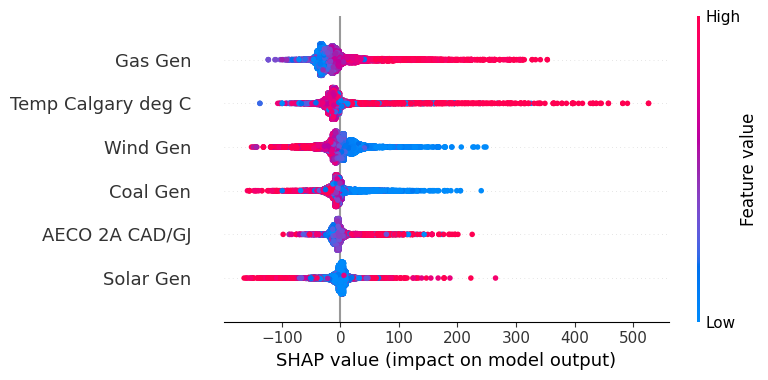

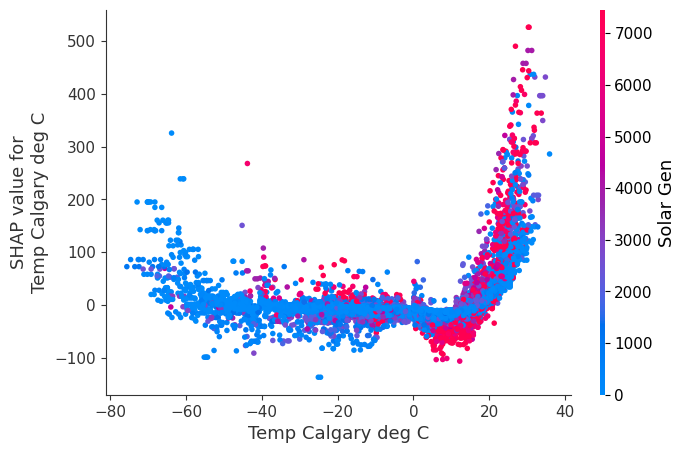

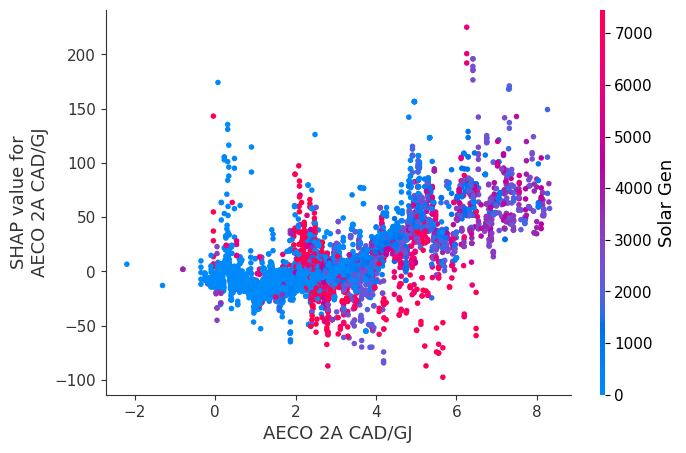

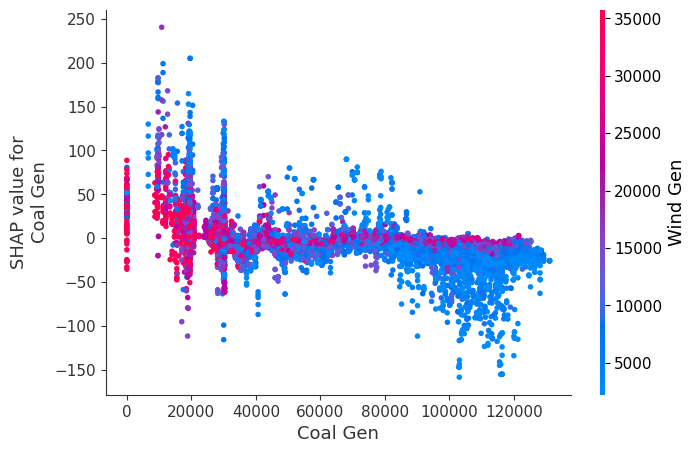

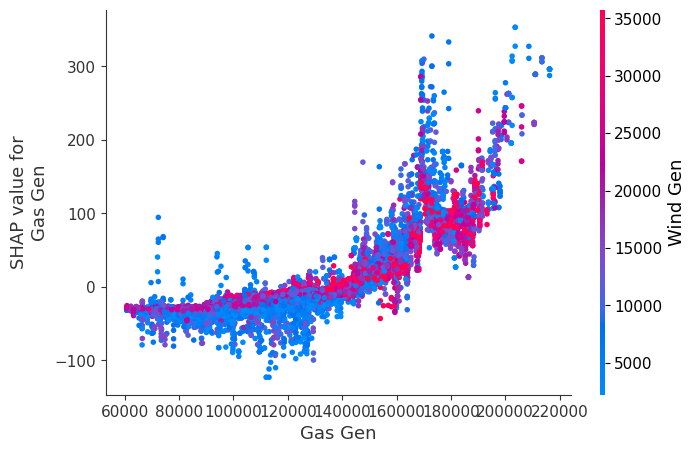

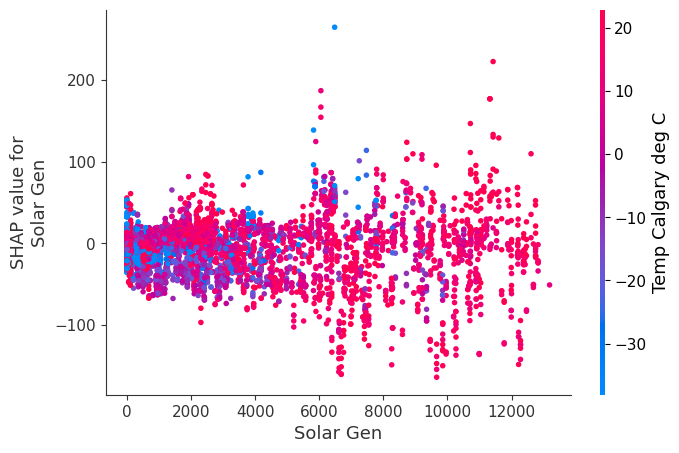

In [51]:
import xgboost as xgb
import shap
from sklearn.model_selection import train_test_split

# Replace NaN values with zeros in production data
data = data.fillna(0)

# Preparing the data for modeling
X = data[['Temp Calgary deg C', 'AECO 2A CAD/GJ', 'Coal Gen', 'Gas Gen', 'Solar Gen', 'Wind Gen']]  # independent variables
y = data['AESO Pool Price CAD/MWh']  # dependent variable

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train an XGBoost model
model = xgb.XGBRegressor()
model.fit(X_train, y_train)

# Create a SHAP explainer
explainer = shap.Explainer(model, X_train)

# Compute SHAP values for test data
shap_values = explainer.shap_values(X_test)

# Visualize feature importance (e.g., summary plot)
feature_names = X_test.columns.tolist()
shap.summary_plot(shap_values, X_test, feature_names=feature_names)

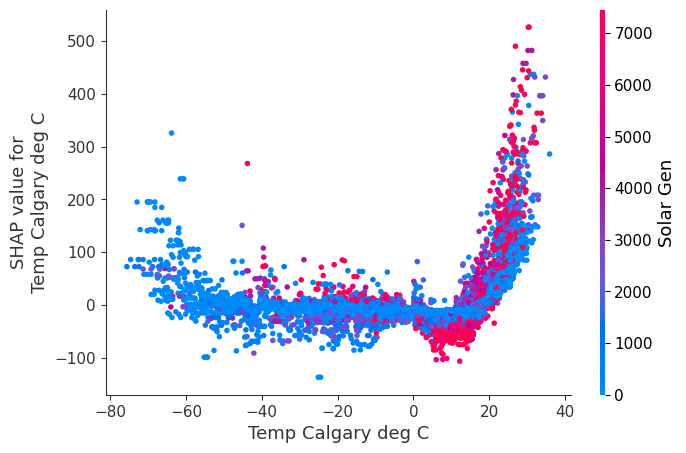

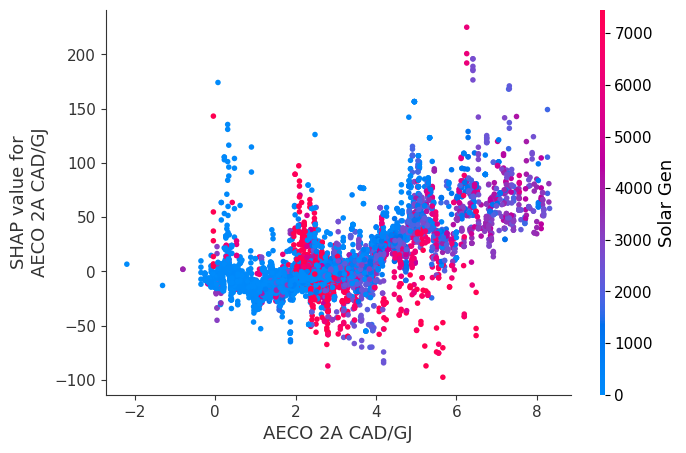

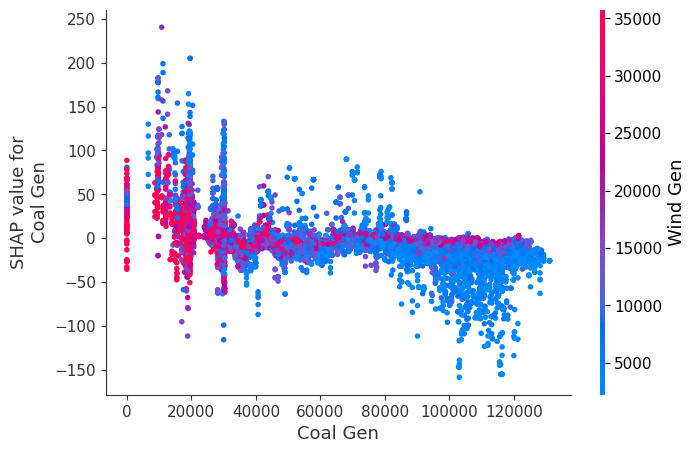

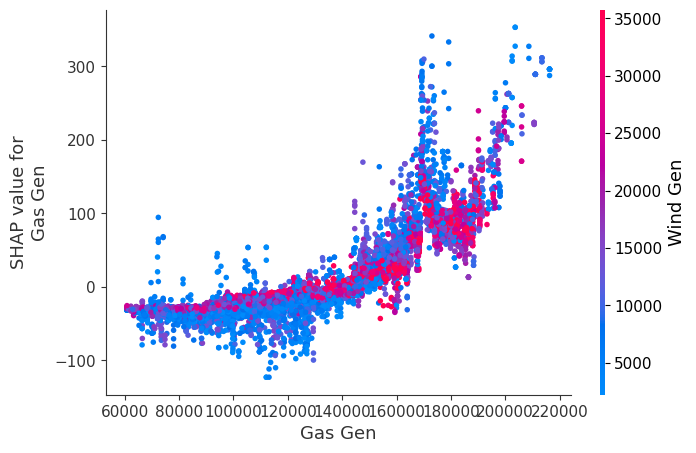

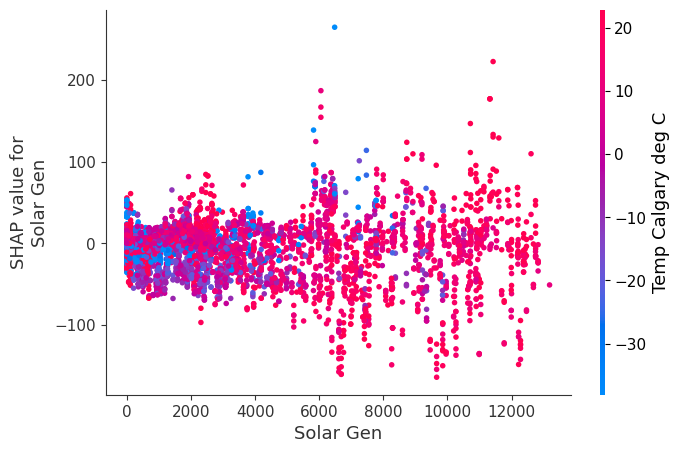

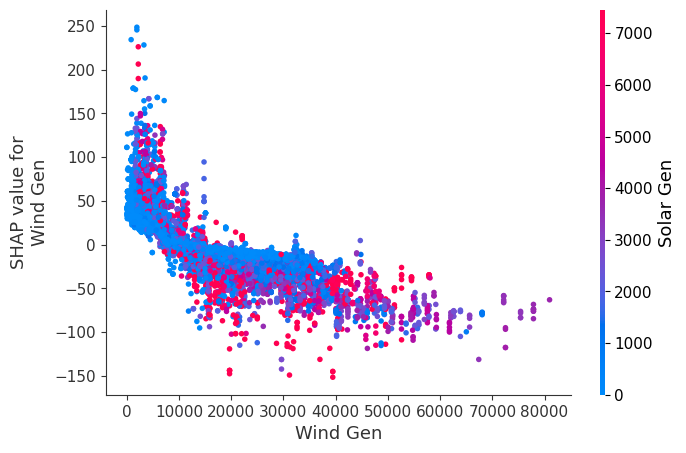

In [54]:
shap.dependence_plot(0, shap_values, X_test, feature_names=feature_names)
shap.dependence_plot(1, shap_values, X_test, feature_names=feature_names)
shap.dependence_plot(2, shap_values, X_test, feature_names=feature_names)
shap.dependence_plot(3, shap_values, X_test, feature_names=feature_names)
shap.dependence_plot(4, shap_values, X_test, feature_names=feature_names)
shap.dependence_plot(5, shap_values, X_test, feature_names=feature_names)

## XGBoost model with SHAP, Random_state=0

 99%|===================| 15635/15778 [00:50<00:00]        

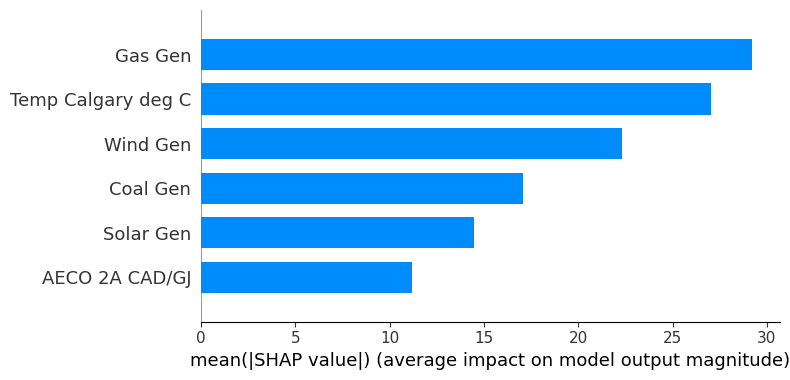

In [43]:
import xgboost as xgb
import shap
from sklearn.model_selection import train_test_split

# Replace NaN values with zeros in production data
data = data.fillna(0)

# Preparing the data for modeling
X = data[['Temp Calgary deg C', 'AECO 2A CAD/GJ', 'Coal Gen', 'Gas Gen', 'Solar Gen', 'Wind Gen']]  # independent variables
y = data['AESO Pool Price CAD/MWh']  # dependent variable

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Train an XGBoost model
model = xgb.XGBRegressor()
model.fit(X_train, y_train)

# Create a SHAP explainer
explainer = shap.Explainer(model, X_train)

# Compute SHAP values for test data
shap_values = explainer.shap_values(X_test)

# Visualize feature importance (e.g., summary plot)
shap.summary_plot(shap_values, X_test, plot_type="bar", show=False)
